In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Dropout,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import logging
import time
import tensorflow as tf
import gc 

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

 # Load dataset

In [ ]:
data = pd.read_csv("C:/Class/HK6/IPrj/Datasets/Leukemia_GSE28497.csv")
data

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,GSM705467.CEL.gz,B-CELL_ALL,7.409521,5.009216,4.173607,7.315369,3.185411,7.620644,3.731541,3.471587,...,2.968822,3.223820,11.968681,12.100004,3.457507,2.967138,2.790814,2.563377,2.860505,2.608381
1,GSM705468.CEL.gz,B-CELL_ALL,7.177109,5.415108,4.426778,7.550818,3.134181,7.685723,3.907953,3.650995,...,2.982888,3.690411,12.318004,12.486741,3.396412,3.109629,2.856499,2.603355,2.908509,2.634063
2,GSM705469.CEL.gz,B-CELL_ALL,6.564918,5.248020,4.252414,7.175169,3.017718,7.956261,3.354557,3.302989,...,2.897425,3.611584,11.748222,11.807578,3.265585,3.057079,2.724642,2.440532,2.626871,2.673293
3,GSM705470.CEL.gz,B-CELL_ALL,6.872028,5.155963,4.388849,7.365933,3.031735,7.830002,3.508926,3.412491,...,3.024722,3.713087,12.208588,12.148604,3.175092,2.896168,2.798296,2.522343,2.762835,2.624163
4,GSM705471.CEL.gz,B-CELL_ALL,7.402105,5.509826,4.284291,7.214947,2.925269,7.789838,3.610425,3.362593,...,3.259802,4.096010,11.641305,11.713311,3.507025,3.119397,2.761294,2.546541,2.748511,2.738165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,GSM706002.CEL.gz,B-CELL_ALL_ETV6-RUNX1,6.692887,4.736595,4.503892,7.484208,3.137376,7.917993,3.858845,3.341846,...,3.215936,3.801296,12.292519,12.288550,3.402729,3.042387,2.965890,2.528686,2.705429,2.762513
277,GSM706003.CEL.gz,B-CELL_ALL_ETV6-RUNX1,6.209500,4.566413,4.637307,7.348777,3.018984,6.423441,3.669993,3.406887,...,3.266234,3.873540,11.971540,12.035205,3.321740,3.030698,2.826285,2.573647,2.942468,2.666361
278,GSM706004.CEL.gz,B-CELL_ALL_ETV6-RUNX1,6.046964,5.252467,4.420044,7.086734,2.913081,7.723025,3.474380,3.309239,...,3.150403,3.756845,11.977577,11.719864,3.541711,2.959812,2.760271,2.514172,2.811914,2.697337
279,GSM706005.CEL.gz,B-CELL_ALL_ETV6-RUNX1,6.347403,4.903981,4.281019,6.989415,2.968945,7.618195,3.492828,3.266248,...,3.204594,3.918882,11.936382,12.019612,3.383822,2.864419,2.739536,2.585459,2.710848,2.769975


 # Preprocessing & visualize dataset

In [ ]:
data = data.drop(columns='samples')
data["type"] = data["type"].replace(
    {"B-CELL_ALL": 0,
     "B-CELL_ALL_ETV6-RUNX1": 1,
     "B-CELL_ALL_HYPERDIP": 2,
     "B-CELL_ALL_T-ALL": 3,
     "B-CELL_ALL_TCF3-PBX1": 4,
     "B-CELL_ALL_HYPO": 5,
     "B-CELL_ALL_MLL": 6,
     }
)
X = data.drop('type', axis=1)
y = data['type']

<ipython-input-3-1ebee11cce2f>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["type"] = data["type"].replace(


In [ ]:
# Class Distribution
print("Initial Class Distribution:")
print(y.value_counts())
num_classes = len(y.unique()) 
all_possible_labels = sorted(y.unique()) 

# Print samples of each type
print("\n--- Sample Data by Type ---")
for class_label in y.unique():
    print(f"\n--- Type {class_label} ---")
    print(data[data['type'] == class_label].head())

Initial Class Distribution:
type
0    74
1    53
2    51
3    46
4    22
5    18
6    17
Name: count, dtype: int64

--- Sample Data by Type ---

--- Type 0 ---
   type  1007_s_at   1053_at    117_at    121_at  1255_g_at   1294_at  \
0     0   7.409521  5.009216  4.173607  7.315369   3.185411  7.620644   
1     0   7.177109  5.415108  4.426778  7.550818   3.134181  7.685723   
2     0   6.564918  5.248020  4.252414  7.175169   3.017718  7.956261   
3     0   6.872028  5.155963  4.388849  7.365933   3.031735  7.830002   
4     0   7.402105  5.509826  4.284291  7.214947   2.925269  7.789838   

    1316_at   1320_at  1405_i_at  ...  AFFX-r2-Hs28SrRNA-5_at  \
0  3.731541  3.471587   4.167374  ...                2.968822   
1  3.907953  3.650995   3.860015  ...                2.982888   
2  3.354557  3.302989   3.335324  ...                2.897425   
3  3.508926  3.412491   3.439769  ...                3.024722   
4  3.610425  3.362593   3.412095  ...                3.259802   

   AFFX-r2

 # Define W-CNN model

In [ ]:
def create_ecn1(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    conv1 = Conv1D(filters=4, kernel_size=3, activation='relu', padding='same')(input_layer) 
    pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)
    flatten = Flatten()(pool1)
    dense1 = Dense(units=6, activation='relu')(flatten)
    output_layer = Dense(units=num_classes, activation='softmax', name='ecn1_output')(dense1)
    return Model(inputs=input_layer, outputs=output_layer)


def create_ecn2(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    conv1 = Conv1D(filters=3, kernel_size=3, activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)
    flatten = Flatten()(pool1)
    dense1 = Dense(units=8, activation='relu')(flatten)
    dropout1 = Dropout(0.3)(dense1)
    output_layer = Dense(units=num_classes, activation='softmax', name='ecn2_output')(dropout1)
    return Model(inputs=input_layer, outputs=output_layer)


def create_ecn3(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    conv1 = Conv1D(filters=5, kernel_size=3, activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)
    flatten = Flatten()(pool1)
    output_layer = Dense(units=num_classes, activation='softmax', name='ecn3_output')(flatten)
    return Model(inputs=input_layer, outputs=output_layer)

In [ ]:
def weighted_ensemble_predictions(predictions, weights):
    if len(predictions) != len(weights):
        raise ValueError("Number of models must match number of weights")

    weighted_predictions = np.array(
        [predictions[i] * weights[i] for i in range(len(predictions))])
    ensemble_predictions = np.sum(weighted_predictions, axis=0)
    ensemble_predictions = np.argmax(ensemble_predictions, axis=1)
    return ensemble_predictions

In [ ]:
epochs = 50
batch_size = 16
learning_rate = 0.001
ensemble_weights = [0.4, 0.3, 0.3]

 # Cross-validation (Correct Dataset Implementation)

2025-07-09 10:01:25,689 - INFO - Initial X_train shape: (238, 22283), X_test shape: (43, 22283)
2025-07-09 10:01:25,693 - INFO - Fold 1/5
2025-07-09 10:01:26,591 - INFO - Fold 1 - Resampled train shape: (348, 22283)
2025-07-09 10:01:26,656 - INFO - Fold 1 - Selected features count: 300
2025-07-09 10:01:26,779 - INFO - Fold 1 - Fitting W-CNN models...
2025-07-09 10:01:52,319 - INFO - Fold 1 - CNN Ensemble trained in 25.54 seconds.
2025-07-09 10:01:52,320 - INFO - Fold 1 - Predicting with W-CNN models...


2025-07-09 10:01:52,764 - WARNING - 5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002751595DDA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2025-07-09 10:01:52,802 - WARNING - 6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002751595DDA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2025-07-09 10:01:52,839 - INFO - Fold 1 - CNN Ensemble predicted in 0.52 seconds.
2025-07-09 10:01:52,840 - INFO - Fold 1 Validation Accuracy: 0.8542


2025-07-09 10:01:53,695 - WARNING - From c:\Class\HK6\IPrj\.venv\Lib\site-packages\keras\src\backend\common\global_state.py:82: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

2025-07-09 10:01:54,041 - INFO - Fold 2/5
2025-07-09 10:01:54,735 - INFO - Fold 2 - Resampled train shape: (348, 22283)
2025-07-09 10:01:54,795 - INFO - Fold 2 - Selected features count: 300
2025-07-09 10:01:54,876 - INFO - Fold 2 - Fitting W-CNN models...
2025-07-09 10:02:20,771 - INFO - Fold 2 - CNN Ensemble trained in 25.90 seconds.
2025-07-09 10:02:20,772 - INFO - Fold 2 - Predicting with W-CNN models...
2025-07-09 10:02:21,212 - INFO - Fold 2 - CNN Ensemble predicted in 0.44 seconds.
2025-07-09 10:02:21,214 - INFO - Fold 2 Validation Accuracy: 0.8333
2025-07-09 10:02:21,569 - INFO - Fold 3/5
2025-07-09 10:02:22,240 - INFO - Fold 3 - Resampled train shape: (357, 22283)
2025-07-09 10:02:22,305 - INFO - Fold 3 - Selected features count: 300
2025-07-09 10:02:2


Average Cross-Validation Accuracy: 0.8529
Average training time: 25.61 s
Average prediction time: 0.48 s


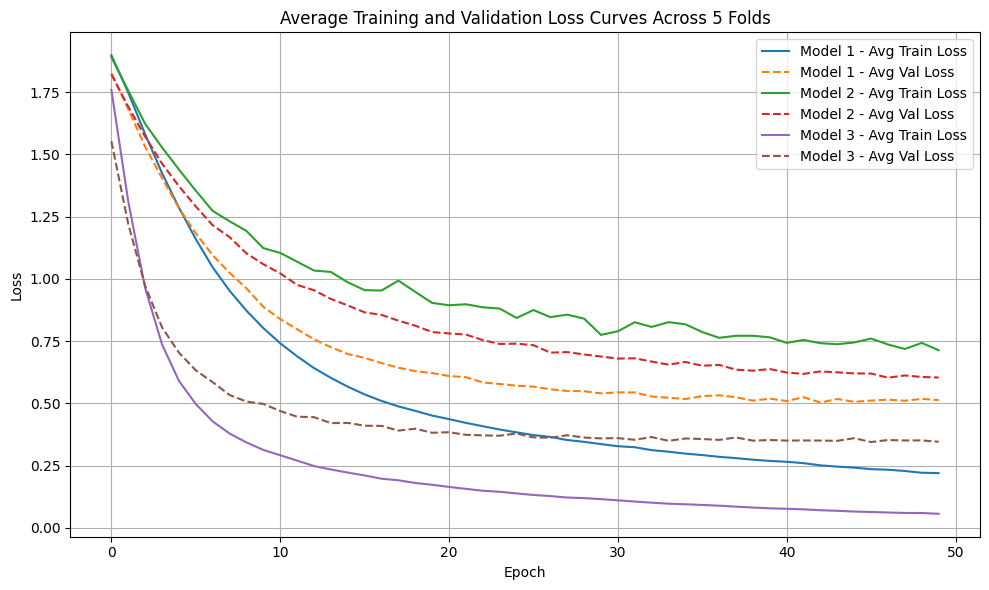

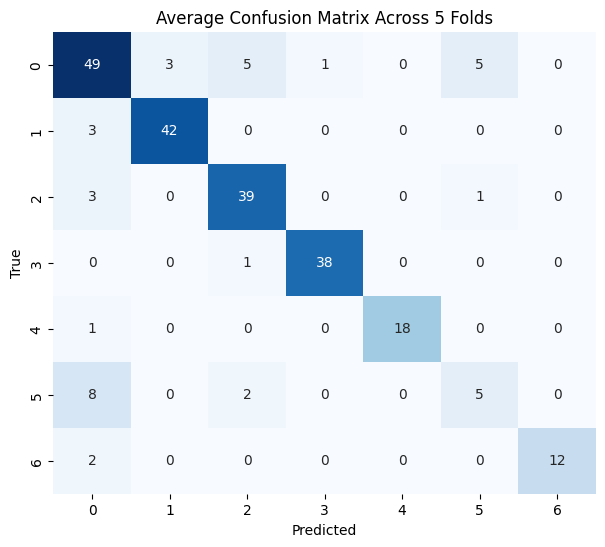

2025-07-09 10:03:43,840 - INFO - Total cross-validation execution time: 138.18 seconds


In [ ]:
total_start_time = time.time()

# Initial split into training and a final, unseen test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
logging.info(f"Initial X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []
all_training_times = []
all_prediction_times = []
all_histories = []
all_cms = [] 

for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    logging.info(f"Fold {fold + 1}/{kf.get_n_splits()}")

    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Preprocessing within the fold: Scaling, SMOTE-Tomek, Feature Selection
    scaler_fold = MinMaxScaler()
    X_train_scaled_fold = scaler_fold.fit_transform(X_train_fold)
    X_val_scaled_fold = scaler_fold.transform(X_val_fold)

    smt_fold = SMOTETomek(random_state=42)
    X_train_resampled_fold, y_train_resampled_fold = smt_fold.fit_resample(X_train_scaled_fold, y_train_fold)
    logging.info(f"Fold {fold + 1} - Resampled train shape: {X_train_resampled_fold.shape}")

    selector_fold = SelectKBest(chi2, k=min(300, X_train_resampled_fold.shape[1]))
    X_train_selected_fold = selector_fold.fit_transform(X_train_resampled_fold, y_train_resampled_fold)
    selected_features_indices_fold = selector_fold.get_support(indices=True)

    # Apply selected features to validation set
    X_val_selected_fold = X_val_scaled_fold[:, selected_features_indices_fold]
    logging.info(f"Fold {fold + 1} - Selected features count: {len(selected_features_indices_fold)}")


    X_train_selected_reshaped_fold = np.expand_dims(X_train_selected_fold, axis=-1)
    X_val_selected_reshaped_fold = np.expand_dims(X_val_selected_fold, axis=-1)

    # Check input shape validity
    if X_train_selected_reshaped_fold.shape[1] == 0:
        logging.error(f"Fold {fold + 1}: X_train_selected_reshaped_fold has 0 features after selection. Skipping fold.")
        continue 

    input_shape = (X_train_selected_reshaped_fold.shape[1], 1)
    ecn1_model = create_ecn1(input_shape, num_classes)
    ecn2_model = create_ecn2(input_shape, num_classes)
    ecn3_model = create_ecn3(input_shape, num_classes)

    ecn1_model.compile(optimizer=Adam(learning_rate=learning_rate),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
    ecn2_model.compile(optimizer=Adam(learning_rate=learning_rate),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
    ecn3_model.compile(optimizer=Adam(learning_rate=learning_rate),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

    y_train_categorical_fold = np.eye(num_classes)[y_train_resampled_fold]
    y_val_categorical_fold = np.eye(num_classes)[y_val_fold]

    train_start_time = time.time()
    logging.info(f"Fold {fold + 1} - Fitting W-CNN models...")
    history1 = ecn1_model.fit(X_train_selected_reshaped_fold, y_train_categorical_fold,
                       epochs=epochs, batch_size=batch_size, verbose=0,
                       validation_data=(X_val_selected_reshaped_fold, y_val_categorical_fold))
    history2 = ecn2_model.fit(X_train_selected_reshaped_fold, y_train_categorical_fold,
                       epochs=epochs, batch_size=batch_size, verbose=0,
                       validation_data=(X_val_selected_reshaped_fold, y_val_categorical_fold))
    history3 = ecn3_model.fit(X_train_selected_reshaped_fold, y_train_categorical_fold,
                       epochs=epochs, batch_size=batch_size, verbose=0,
                       validation_data=(X_val_selected_reshaped_fold, y_val_categorical_fold))

    train_end_time = time.time()
    training_time = train_end_time - train_start_time
    logging.info(f"Fold {fold + 1} - CNN Ensemble trained in {training_time:.2f} seconds.")
    all_training_times.append(training_time)
    
    histories = [history1, history2, history3]
    all_histories.append(histories)
    
    predict_start_time = time.time()
    logging.info(f"Fold {fold + 1} - Predicting with W-CNN models...")
    ecn1_predictions_fold = ecn1_model.predict(X_val_selected_reshaped_fold, verbose=0)
    ecn2_predictions_fold = ecn2_model.predict(X_val_selected_reshaped_fold, verbose=0)
    ecn3_predictions_fold = ecn3_model.predict(X_val_selected_reshaped_fold, verbose=0)

    ensemble_predictions_fold = weighted_ensemble_predictions(
        [ecn1_predictions_fold, ecn2_predictions_fold, ecn3_predictions_fold],
        ensemble_weights)
    
    predict_end_time = time.time()
    prediction_time = predict_end_time - predict_start_time
    logging.info(f"Fold {fold + 1} - CNN Ensemble predicted in {prediction_time:.2f} seconds.")
    all_prediction_times.append(prediction_time)

    accuracy_fold = accuracy_score(y_val_fold, ensemble_predictions_fold)
    cv_accuracies.append(accuracy_fold)
    logging.info(f"Fold {fold + 1} Validation Accuracy: {accuracy_fold:.4f}")

    # Collect confusion matrix for averaging
    cm_fold = confusion_matrix(y_val_fold, ensemble_predictions_fold, labels=all_possible_labels)
    all_cms.append(cm_fold)

    # Clean up models for the next fold to free up memory
    del ecn1_model, ecn2_model, ecn3_model
    tf.keras.backend.clear_session()
    gc.collect()

print(f"\nAverage Cross-Validation Accuracy: {np.mean(cv_accuracies):.4f}")
print(f"Average training time: {np.mean(all_training_times):.2f} s")
print(f"Average prediction time: {np.mean(all_prediction_times):.2f} s")

# Calculate average loss curves
summed_train_loss = {f'model_{i+1}': np.zeros(epochs) for i in range(3)}
summed_val_loss = {f'model_{i+1}': np.zeros(epochs) for i in range(3)}

for fold_histories in all_histories:
    for i, history in enumerate(fold_histories):
        if history is not None: 
            train_loss_data = np.array(history.history['loss'])
            val_loss_data = np.array(history.history['val_loss'])
            
            min_len = min(len(train_loss_data), len(val_loss_data), epochs) 
            
            summed_train_loss[f'model_{i+1}'] += train_loss_data[:min_len]
            summed_val_loss[f'model_{i+1}'] += val_loss_data[:min_len]

# Calculate average
num_folds_successful = len(all_histories) # Use this in case some folds were skipped
avg_train_loss = {k: v / num_folds_successful for k, v in summed_train_loss.items()}
avg_val_loss = {k: v / num_folds_successful for k, v in summed_val_loss.items()}

# Plot average loss curves
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(avg_train_loss[f'model_{i+1}'], label=f'Model {i+1} - Avg Train Loss')
    plt.plot(avg_val_loss[f'model_{i+1}'], label=f'Model {i+1} - Avg Val Loss', linestyle='--')
    
plt.title(f"Average Training and Validation Loss Curves Across {kf.n_splits} Folds")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
    
# Calculate and plot average confusion matrix
if all_cms: # Check if there are any confusion matrices collected
    avg_cm = np.sum(all_cms, axis=0) 
    
    plt.figure(figsize=(7, 6))
    sns.heatmap(avg_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=all_possible_labels, yticklabels=all_possible_labels, cbar=False)
    plt.title(f"Average Confusion Matrix Across {kf.n_splits} Folds")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
else:
    logging.warning("No confusion matrices collected for plotting.")

total_end_time = time.time()    
total_duration = total_end_time - total_start_time
logging.info(f"Total cross-validation execution time: {total_duration:.2f} seconds")

# Final Model Training and Evaluation on Unseen Test Set

In [ ]:
start_preprocessing_final = time.time()

# Preprocess the entire X_train (from initial split) for final model training
scaler_final = MinMaxScaler()
X_train_scaled_final = scaler_final.fit_transform(X_train)
smt_final = SMOTETomek(random_state=42)
X_train_resampled_final, y_train_resampled_final = smt_final.fit_resample(X_train_scaled_final, y_train)
selector_final = SelectKBest(chi2, k=min(300, X_train_resampled_final.shape[1])) 
X_train_selected_final = selector_final.fit_transform(X_train_resampled_final, y_train_resampled_final)
X_train_selected_reshaped_final = np.expand_dims(X_train_selected_final, axis=-1)
logging.info(f"Final training set shape after preprocessing: {X_train_selected_reshaped_final.shape}")


preprocessing_final_duration = time.time() - start_preprocessing_final
print(f"Final training preprocessing took {preprocessing_final_duration:.2f} seconds")

2025-07-09 10:03:44,582 - INFO - Final training set shape after preprocessing: (441, 300, 1)


Final training preprocessing took 0.70 seconds


In [ ]:
# Preprocess the held-out X_test using scalers/selectors fitted on X_train_final
X_test_scaled = scaler_final.transform(X_test)
X_test_selected = selector_final.transform(X_test_scaled)
X_test_selected_reshaped = np.expand_dims(X_test_selected, axis=-1)
logging.info(f"Final test set shape after preprocessing: {X_test_selected_reshaped.shape}")

2025-07-09 10:03:44,671 - INFO - Final test set shape after preprocessing: (43, 300, 1)


In [ ]:
# Re-instantiate and compile models for final training
input_shape_final_model = (X_train_selected_reshaped_final.shape[1], 1) 
ecn1_final_model = create_ecn1(input_shape_final_model, num_classes)
ecn2_final_model = create_ecn2(input_shape_final_model, num_classes)
ecn3_final_model = create_ecn3(input_shape_final_model, num_classes)

ecn1_final_model.compile(optimizer=Adam(learning_rate=learning_rate),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
ecn2_final_model.compile(optimizer=Adam(learning_rate=learning_rate),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
ecn3_final_model.compile(optimizer=Adam(learning_rate=learning_rate),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

In [ ]:
y_train_categorical_final = np.eye(num_classes)[y_train_resampled_final]
y_test_categorical_final = np.eye(num_classes)[y_test]

In [ ]:
start_training_final = time.time()
logging.info("Training final W-CNN models...")

ecn1_final_model.fit(X_train_selected_reshaped_final, y_train_categorical_final,
                      epochs=epochs, batch_size=batch_size, verbose=0)
ecn2_final_model.fit(X_train_selected_reshaped_final, y_train_categorical_final,
                      epochs=epochs, batch_size=batch_size, verbose=0)
ecn3_final_model.fit(X_train_selected_reshaped_final, y_train_categorical_final,
                      epochs=epochs, batch_size=batch_size, verbose=0)

training_final_duration = time.time() - start_training_final
print(f"Final model training took {training_final_duration:.2f} seconds")

2025-07-09 10:03:44,800 - INFO - Training final W-CNN models...


Final model training took 17.38 seconds


In [ ]:
start_prediction_final = time.time()
logging.info("Predicting with final W-CNN models on test set...")

ecn1_predictions_test = ecn1_final_model.predict(X_test_selected_reshaped, verbose=0)
ecn2_predictions_test = ecn2_final_model.predict(X_test_selected_reshaped, verbose=0)
ecn3_predictions_test = ecn3_final_model.predict(X_test_selected_reshaped, verbose=0)

ensemble_predictions_test = weighted_ensemble_predictions(
    [ecn1_predictions_test, ecn2_predictions_test, ecn3_predictions_test],
    ensemble_weights)

prediction_final_duration = time.time() - start_prediction_final
print(f"Final model prediction took {prediction_final_duration:.2f} seconds")

2025-07-09 10:04:02,195 - INFO - Predicting with final W-CNN models on test set...


Final model prediction took 0.47 seconds



****** Final Test Set Evaluation ******
Test Set Accuracy: 0.8605
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.89      1.00      0.94         8
           2       0.88      0.88      0.88         8
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         3
           5       0.33      0.33      0.33         3
           6       1.00      1.00      1.00         3

    accuracy                           0.86        43
   macro avg       0.84      0.85      0.84        43
weighted avg       0.86      0.86      0.86        43


Final Test Set Confusion Matrix:
 [[8 0 1 0 0 2 0]
 [0 8 0 0 0 0 0]
 [1 0 7 0 0 0 0]
 [0 0 0 7 0 0 0]
 [0 0 0 0 3 0 0]
 [1 1 0 0 0 1 0]
 [0 0 0 0 0 0 3]]


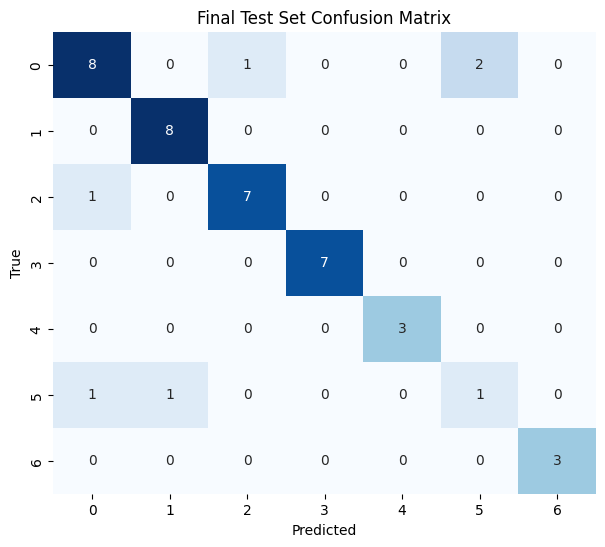

In [ ]:
# Final Evaluation Metrics
accuracy_test = accuracy_score(y_test, ensemble_predictions_test)
report_test = classification_report(y_test, ensemble_predictions_test, labels=all_possible_labels, zero_division=0) # Ensure all labels are included in report

print("\n****** Final Test Set Evaluation ******")
print(f"Test Set Accuracy: {accuracy_test:.4f}")
print("Test Set Classification Report:\n", report_test)

cm_final_test = confusion_matrix(y_test, ensemble_predictions_test, labels=all_possible_labels)
print("\nFinal Test Set Confusion Matrix:\n", cm_final_test)

# Plot final confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm_final_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_possible_labels, yticklabels=all_possible_labels, cbar=False)
plt.title("Final Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
print("\n--- Class Distribution in y_train (Original for split) ---")
print(y_train.value_counts())
print("\n--- Class Distribution in y_test (Original held-out) ---")
print(y_test.value_counts())
print("\n--- Class Distribution in y_train_resampled_final (After SMOTETomek for final training) ---")
print(pd.Series(y_train_resampled_final).value_counts())


--- Class Distribution in y_train (Original for split) ---
type
0    63
1    45
2    43
3    39
4    19
5    15
6    14
Name: count, dtype: int64

--- Class Distribution in y_test (Original held-out) ---
type
0    11
2     8
1     8
3     7
5     3
4     3
6     3
Name: count, dtype: int64

--- Class Distribution in y_train_resampled_final (After SMOTETomek for final training) ---
type
3    63
1    63
0    63
2    63
6    63
4    63
5    63
Name: count, dtype: int64


In [ ]:
print("\n--- Inspecting First 20 Predictions on Final Test Set ---")
print("True Labels: ", y_test[:20].tolist())
print("Predicted Labels: ", ensemble_predictions_test[:20].tolist())


--- Inspecting First 20 Predictions on Final Test Set ---
True Labels:  [0, 3, 5, 4, 5, 2, 0, 1, 3, 2, 0, 2, 2, 1, 0, 1, 3, 5, 1, 4]
Predicted Labels:  [0, 3, 5, 4, 0, 0, 0, 1, 3, 2, 5, 2, 2, 1, 0, 1, 3, 1, 1, 4]
